# Eliator Network Validation

Overview

This notebook investigates how to apply network validation from eliator to build a DAG.



In [7]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from indra_cogex.client import Neo4jClient

from MScausality.graph_construction.single_node import build_network
import MScausality.data_analysis.gene_set as gs
from MScausality.graph_construction.graph import GraphBuilder


## Prep data

In [17]:
raw_data = pd.read_csv("../../data/Schweppe/Belinostat_all_norm.csv")

long_df = pd.melt(raw_data, id_vars = ['Uniprot', 'Gene', 'Drug', 'Line'], 
        value_vars = ['Rep1_norm2', 'Rep2_norm2', 'Rep3_norm2'], 
        value_name = 'Intensity', var_name="replicate")

long_df = long_df[long_df["Intensity"] < 8.5]
long_df.loc[:, "Intensity"] = np.log2(long_df.loc[:, "Intensity"])
long_df.loc[:, "Replicate"] = long_df.loc[:, "Drug"] + "_" + long_df.loc[:, "Line"]+ "_" + long_df.loc[:, "replicate"]
len(long_df.loc[:, "Replicate"].unique())

long_df = long_df.groupby(["Gene", "Replicate"])["Intensity"].mean().reset_index()
input_data = long_df.pivot(index="Replicate", columns="Gene", values="Intensity")

In [18]:
input_data.head()

Gene,A1BG,A1CF,A2M,A2ML1,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Replicate,,,,,,,,,,,,,,,,,,,,,
Belinostat_A549_Rep1_norm2,3.061187,-1.937123,NaN,NaN,-0.159537,-0.308481,NaN,1.045930,0.402788,-0.634048,...,NaN,-0.099252,0.360678,NaN,NaN,NaN,0.695385,-1.825623,1.154774,-1.728124
Belinostat_A549_Rep2_norm2,NaN,-1.609184,NaN,NaN,-0.192971,0.323281,NaN,0.883503,0.294949,-0.571617,...,NaN,0.057900,-0.392966,NaN,NaN,NaN,0.537846,-2.126252,1.489350,1.551969
Belinostat_A549_Rep3_norm2,2.860346,-2.329601,NaN,NaN,-0.092648,-0.114330,NaN,0.504563,0.386542,-0.655025,...,NaN,0.009563,0.214612,NaN,NaN,NaN,0.558460,-2.149611,1.315193,-1.610193
Belinostat_Ad1_Rep1_norm2,NaN,NaN,3.067489,NaN,-0.398765,0.370729,1.088392,0.545100,0.457614,-0.428159,...,NaN,-0.322197,-1.261786,NaN,NaN,NaN,0.121387,-0.336375,1.206982,-1.848010
Belinostat_Ad1_Rep2_norm2,NaN,NaN,NaN,NaN,-0.368035,-0.494018,0.948451,0.456305,0.445395,-0.449225,...,NaN,-0.401540,-1.705712,NaN,NaN,NaN,0.554873,-0.339113,1.182284,-1.920320


0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


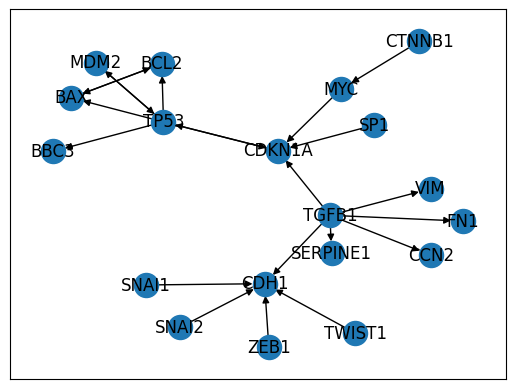

In [19]:
client = Neo4jClient(url=os.getenv("API_URL"), 
                    auth=(os.getenv("USER"), 
                        os.getenv("PASSWORD"))
                )

network = build_network(["CDKN1A"], "gene", client,
                        evidence_count=[50, 150, 150], levels=3,
                        upstream=True, downstream=True)


graph = nx.DiGraph()
for i in range(len(network)):
    graph.add_edge(network.loc[i, "source_hgnc_symbol"], 
                    network.loc[i, "target_hgnc_symbol"])
pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
nx.draw_networkx(graph, pos)

plt.show()

network.reset_index(drop=True).to_csv(
        "../../data/INDRA_networks/schweppe_networks/cdkn1a_model.tsv",
        sep="\t",
        index=False)

## Grab INDRA net

Preparing experimental data...
Preparing INDRA statements...
Building graph...
Fixing cycles...


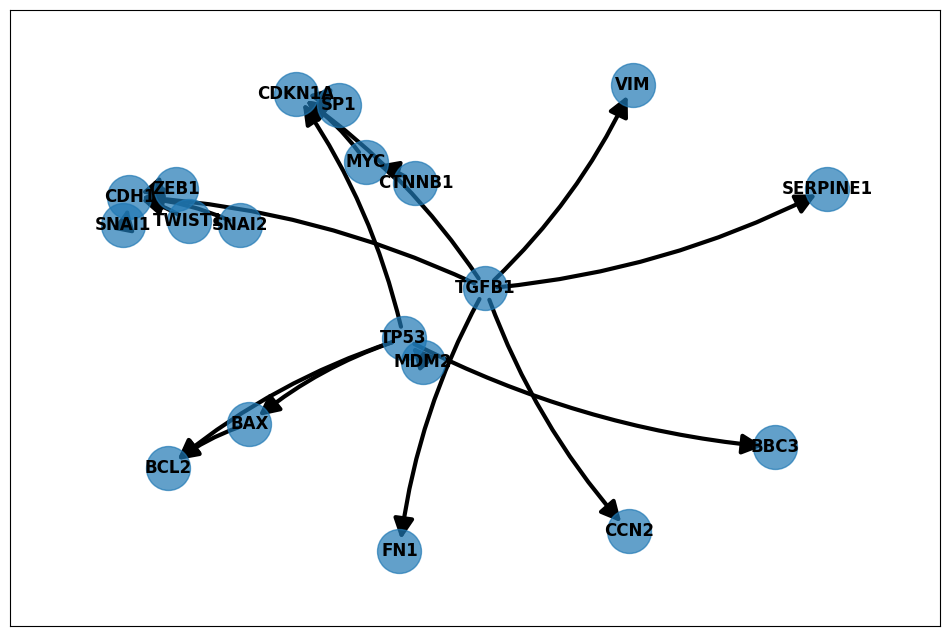

In [20]:
long_df = long_df.rename(columns={"Gene": "Protein",
                                  "Replicate": "Run",
                                  "Intensity": "Abundance"})
train_data = long_df.loc[long_df["Run"].str.contains("DMSO")]

diff_protein_dag = GraphBuilder(network, train_data, True)

diff_protein_dag.build_full_graph(data_type="LF",
                        protein_format="Gene_Name_Organism",
                        source_name="source_hgnc_symbol",
                        target_name="target_hgnc_symbol")
diff_protein_dag.build_dag()
diff_protein_dag.create_latent_graph()
diff_protein_dag.plot_latent_graph(figure_size=(12, 8))

In [39]:
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.conditional_independencies import get_conditional_independencies

In [35]:
nodes = [str(i) for i in list(diff_protein_dag.causal_graph.nodes())]
nodes

['MYC',
 'TGFB1',
 'SNAI1',
 'BAX',
 'CCN2',
 'TWIST1',
 'SP1',
 'VIM',
 'SERPINE1',
 'BCL2',
 'FN1',
 'TP53',
 'ZEB1',
 'CDKN1A',
 'MDM2',
 'SNAI2',
 'CDH1',
 'BBC3',
 'CTNNB1']

In [37]:
diff_protein_dag.experimental_data.reset_index(drop=True).loc[:, nodes]

Protein,MYC,TGFB1,SNAI1,BAX,CCN2,TWIST1,SP1,VIM,SERPINE1,BCL2,FN1,TP53,ZEB1,CDKN1A,MDM2,SNAI2,CDH1,BBC3,CTNNB1
0,NaN,0.512041,NaN,0.713772,-0.001725,NaN,-0.445613,-1.071011,2.154824,NaN,0.002303,-1.837412,-0.263675,0.521611,NaN,NaN,0.526050,NaN,-0.702810
1,NaN,0.546962,NaN,0.626665,-0.191117,NaN,-0.253998,-1.011504,1.855017,NaN,0.057587,-2.587236,0.119057,0.521611,NaN,NaN,0.810199,NaN,-0.759083
2,NaN,0.552830,NaN,0.589709,-0.528614,NaN,-0.211237,-0.965761,1.661658,NaN,0.057724,-2.184895,0.132216,0.521611,NaN,NaN,0.150951,NaN,-0.717493
3,NaN,0.126488,NaN,0.796012,1.024949,NaN,-0.080407,-0.253897,NaN,NaN,0.028150,-1.773468,0.458385,1.087920,0.676610,NaN,-1.007986,NaN,-0.371772
4,NaN,0.200781,NaN,0.780186,1.256939,NaN,-0.068171,-0.280923,3.013244,NaN,-0.227150,-1.817315,0.686332,1.169928,0.037027,NaN,-0.876813,NaN,-0.475929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,NaN,-0.621422,NaN,-0.217012,0.626225,NaN,0.405826,-5.193081,2.138918,NaN,-1.671982,3.028707,NaN,0.342692,NaN,NaN,2.161382,NaN,0.210059
68,NaN,-0.552915,NaN,-0.395213,0.745639,NaN,0.182652,-5.036417,2.149553,NaN,-1.513797,NaN,NaN,0.559086,NaN,NaN,1.752725,NaN,0.235138
69,NaN,0.677941,NaN,0.432568,0.779527,NaN,-0.013726,-0.237620,2.523341,NaN,2.649741,NaN,-0.108504,0.155904,-0.458487,1.606330,2.312480,-0.642534,0.834404
70,NaN,0.921080,NaN,0.353361,0.711308,NaN,-0.242351,-0.199227,2.337149,NaN,2.689377,NaN,0.252219,0.156538,-0.218090,1.840887,2.499625,-0.642534,0.894329


In [50]:
get_conditional_independencies(diff_protein_dag.causal_graph, max_conditions=2)

{DSeparationJudgement(separated=True, left=BAX, right=BBC3, conditions=(TP53,)),
 DSeparationJudgement(separated=True, left=BAX, right=CCN2, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=CDH1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=CDKN1A, conditions=(TP53,)),
 DSeparationJudgement(separated=True, left=BAX, right=CTNNB1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=FN1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=MDM2, conditions=(TP53,)),
 DSeparationJudgement(separated=True, left=BAX, right=MYC, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=SERPINE1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=SNAI1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=SNAI2, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=SP1, conditions=()),
 DSeparationJudgement(separated=True, left=BAX, right=TGFB1, condi

In [67]:
dsep = list(get_conditional_independencies(diff_protein_dag.causal_graph, max_conditions=2))[4]

In [70]:
print(dsep.left.name)
print(dsep.right.name)
print(dsep.conditions)

CDKN1A
FN1
(TGFB1,)


In [23]:
print_graph_falsifications(
    diff_protein_dag.causal_graph,
    diff_protein_dag.experimental_data.reset_index(drop=True))

ValueError: array must not contain infs or NaNs

In [1]:
from eliater.examples import example_2
from eliater.network_validation import print_graph_falsifications

graph = example_2.graph
observational_df = example_2.generate_data(500, seed=1)

print_graph_falsifications(graph, data=observational_df, verbose=True)

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Of the 14 d-separations implied by the network's structure, only 1(7.14%) rejected the null hypothesis at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the network unmodified.]

Finished in 0.30 seconds.



,left,right,given,stats,p,dof,p_adj,p_adj_significant
0,Y,Z2,M2|Z3,0.392472,7.336475e-20,None,1.027106e-18,True
1,M1,Z3,Z2,0.108302,1.540281e-02,None,2.002366e-01,False
2,M2,Z2,X,0.087466,5.062457e-02,None,6.074948e-01,False
3,X,Z3,Z2,0.079871,7.436529e-02,None,8.180182e-01,False
4,M2,X,M1,0.043546,3.311734e-01,None,1.000000e+00,False
5,M1,Y,M2|Z3,0.012480,7.807331e-01,None,1.000000e+00,False
6,M1,Z1,X,-0.010814,8.093950e-01,None,1.000000e+00,False
7,Z1,Z3,Z2,0.070001,1.179881e-01,None,1.000000e+00,False
8,X,Z2,Z1,-0.010954,8.069659e-01,None,1.000000e+00,False
9,M1,Z2,X,0.037264,4.057125e-01,None,1.000000e+00,False
